In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.gaussian_process.kernels import RBF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrices # helps format the input and target variables for ML
from sklearn.model_selection import RepeatedKFold, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.gaussian_process.kernels import RBF,Matern,RationalQuadratic,ExpSineSquared,DotProduct,WhiteKernel
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# read data from the .csv file

df = pd.read_csv("am_measurement_data.csv")
df.head()

,print_serial,design,print_location,hardware,layout,material,color,feature_category,feature_class,feature_id,feature_category_class,material_color,part_id,print_x_mm,print_y_mm,CAD_mm,measure_mm,DFT_mm,print_dist_from_origin_mm,thermal_cure
0,KR70035C,bracket,7,1,1,EPX,black,center,dist_length,bracket_dist_mm_c,center_dist_length,EPX_black,KR70035C_7,42,48,15.0,14.969881,-0.030119,63.780875,True
1,KR70035C,bracket,7,1,1,EPX,black,height,height,bracket_height_mm,height_height,EPX_black,KR70035C_7,42,48,8.0,7.644579,-0.355421,63.780875,True
2,KR70035C,bracket,7,1,1,EPX,black,inner,dia,bracket_inner_dia_mm_a,inner_dia,EPX_black,KR70035C_7,42,48,2.5,2.404393,-0.095607,63.780875,True
3,KR70035C,bracket,7,1,1,EPX,black,inner,length,bracket_inner_length_mm_b,inner_length,EPX_black,KR70035C_7,42,48,15.0,14.928239,-0.071761,63.780875,True
4,KR70035C,bracket,7,1,1,EPX,black,outer,thick,bracket_thick_mm_a,outer_thick,EPX_black,KR70035C_7,42,48,2.0,1.995835,-0.004165,63.780875,True


In [3]:
# # Simply drop the columns which will be not used for training and testing 
# # Then, use pandas dataframe for splitting training and testing data

# df = df.drop(columns=['print_serial', 'design', 'print_location', 'layout', 'color', 'feature_id', 'feature_category_class', 'material_color', 'part_id', 'measure_mm', 'thermal_cure'])
# df.head()

In [4]:
# Define the target (y) variable and the input (x) variables
# Notice "dmatrices" one-hot-encodes categorical variables for us 

y, x = dmatrices('DFT_mm ~ CAD_mm + print_x_mm + print_y_mm + print_dist_from_origin_mm + C(material) + C(hardware) + C(feature_category) + C(feature_class)', df, return_type="dataframe")
y = y.astype(float)
x = x.astype(float)
y.head()    # target variable to be predicted

,DFT_mm
0,-0.030119
1,-0.355421
2,-0.095607
3,-0.071761
4,-0.004165


In [5]:
#Scaling the data using StandardScaler
# x = preprocessing.StandardScaler().fit(x)

In [6]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state = 2022)

# Use the same function above for the validation set
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=True, random_state= 2022) # 0.25 x 0.8 = 0.2


print("x_train shape: {}".format(x_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
# print("X_val shape: {}".format(x_val.shape))
# print("y val shape: {}".format(y_val.shape))

x_train shape: (1620, 16)
x_test shape: (405, 16)
y_train shape: (1620, 1)
y_test shape: (405, 1)


In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
# y_train = sc.fit_transform(y_train)
# y_test = sc.transform(y_test)

In [8]:
# y = sc.fit_transform(y)

In [9]:
print(x_train)

[[ 0.         -0.71793801 -1.1110728  ... -0.38986625 -1.39780997
  -0.29891937]
 [ 0.         -0.71793801  0.90003104 ... -1.55300314  1.42922143
   1.58414351]
 [ 0.         -0.71793801 -1.1110728  ... -1.55300314  0.72246358
   1.18567065]
 ...
 [ 0.         -0.71793801 -1.1110728  ... -0.00215396  0.72246358
  -1.50433292]
 [ 0.         -0.71793801  0.90003104 ... -0.77757855  0.01570573
  -0.74014327]
 [ 0.          1.39287792 -1.1110728  ...  1.16098293 -1.39780997
   0.83927851]]


In [10]:
print(y_train)

        DFT_mm
212  -0.175092
1800 -0.091499
93   -0.021332
1479  0.119733
1951 -0.272932
...        ...
1713  0.159658
624  -0.021400
173  -0.156673
1244  0.082803
893  -0.068585

[1620 rows x 1 columns]


In [11]:
# x_train=x_train.flatten()
y_train1=np.array(y_train).flatten()
# x_train.shape
y_train1.shape

(1620,)

In [12]:
# x_train.shape

In [13]:
# sns.kdeplot(y_train1, alpha=0.3, shade=True)
# x = plt.gca()
# plt.xlabel("DFT_mm", fontsize = 18)
# plt.ylabel("Density", fontsize = 18)
# plt.xticks(fontsize = 18)
# plt.yticks(fontsize = 18)
# fig = plt.gcf()
# fig.set_size_inches(7, 5)
# fig.set_dpi(100)
# plt.show()

In [14]:

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def GPR(kernel, n_restarts_optimizer):
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, random_state=2022)
    return gaussian_process

# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) * 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1, alpha_bounds=(1e-5, 1e15))
kernel = Matern() + WhiteKernel()

GPregressor = GPR(kernel, 50)
GPregressor.fit(x_train, y_train)


GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=50, random_state=2022)

In [15]:
mean_prediction, std_prediction = GPregressor.predict(x_test, return_std=True)

In [16]:
np.average(std_prediction)

0.053165989971531984

In [18]:
# y_pred = regr.predict(x_test)
rmse = mean_squared_error(y_test, mean_prediction, squared=False)
R2 = r2_score(y_test, mean_prediction)

print("RMSE: {:.3f} mm".format(rmse))
print("R2_score: {:.3f}".format(R2))

RMSE: 0.049 mm
R2_score: 0.926


In [17]:
mean_prediction.flatten().shape

(405,)

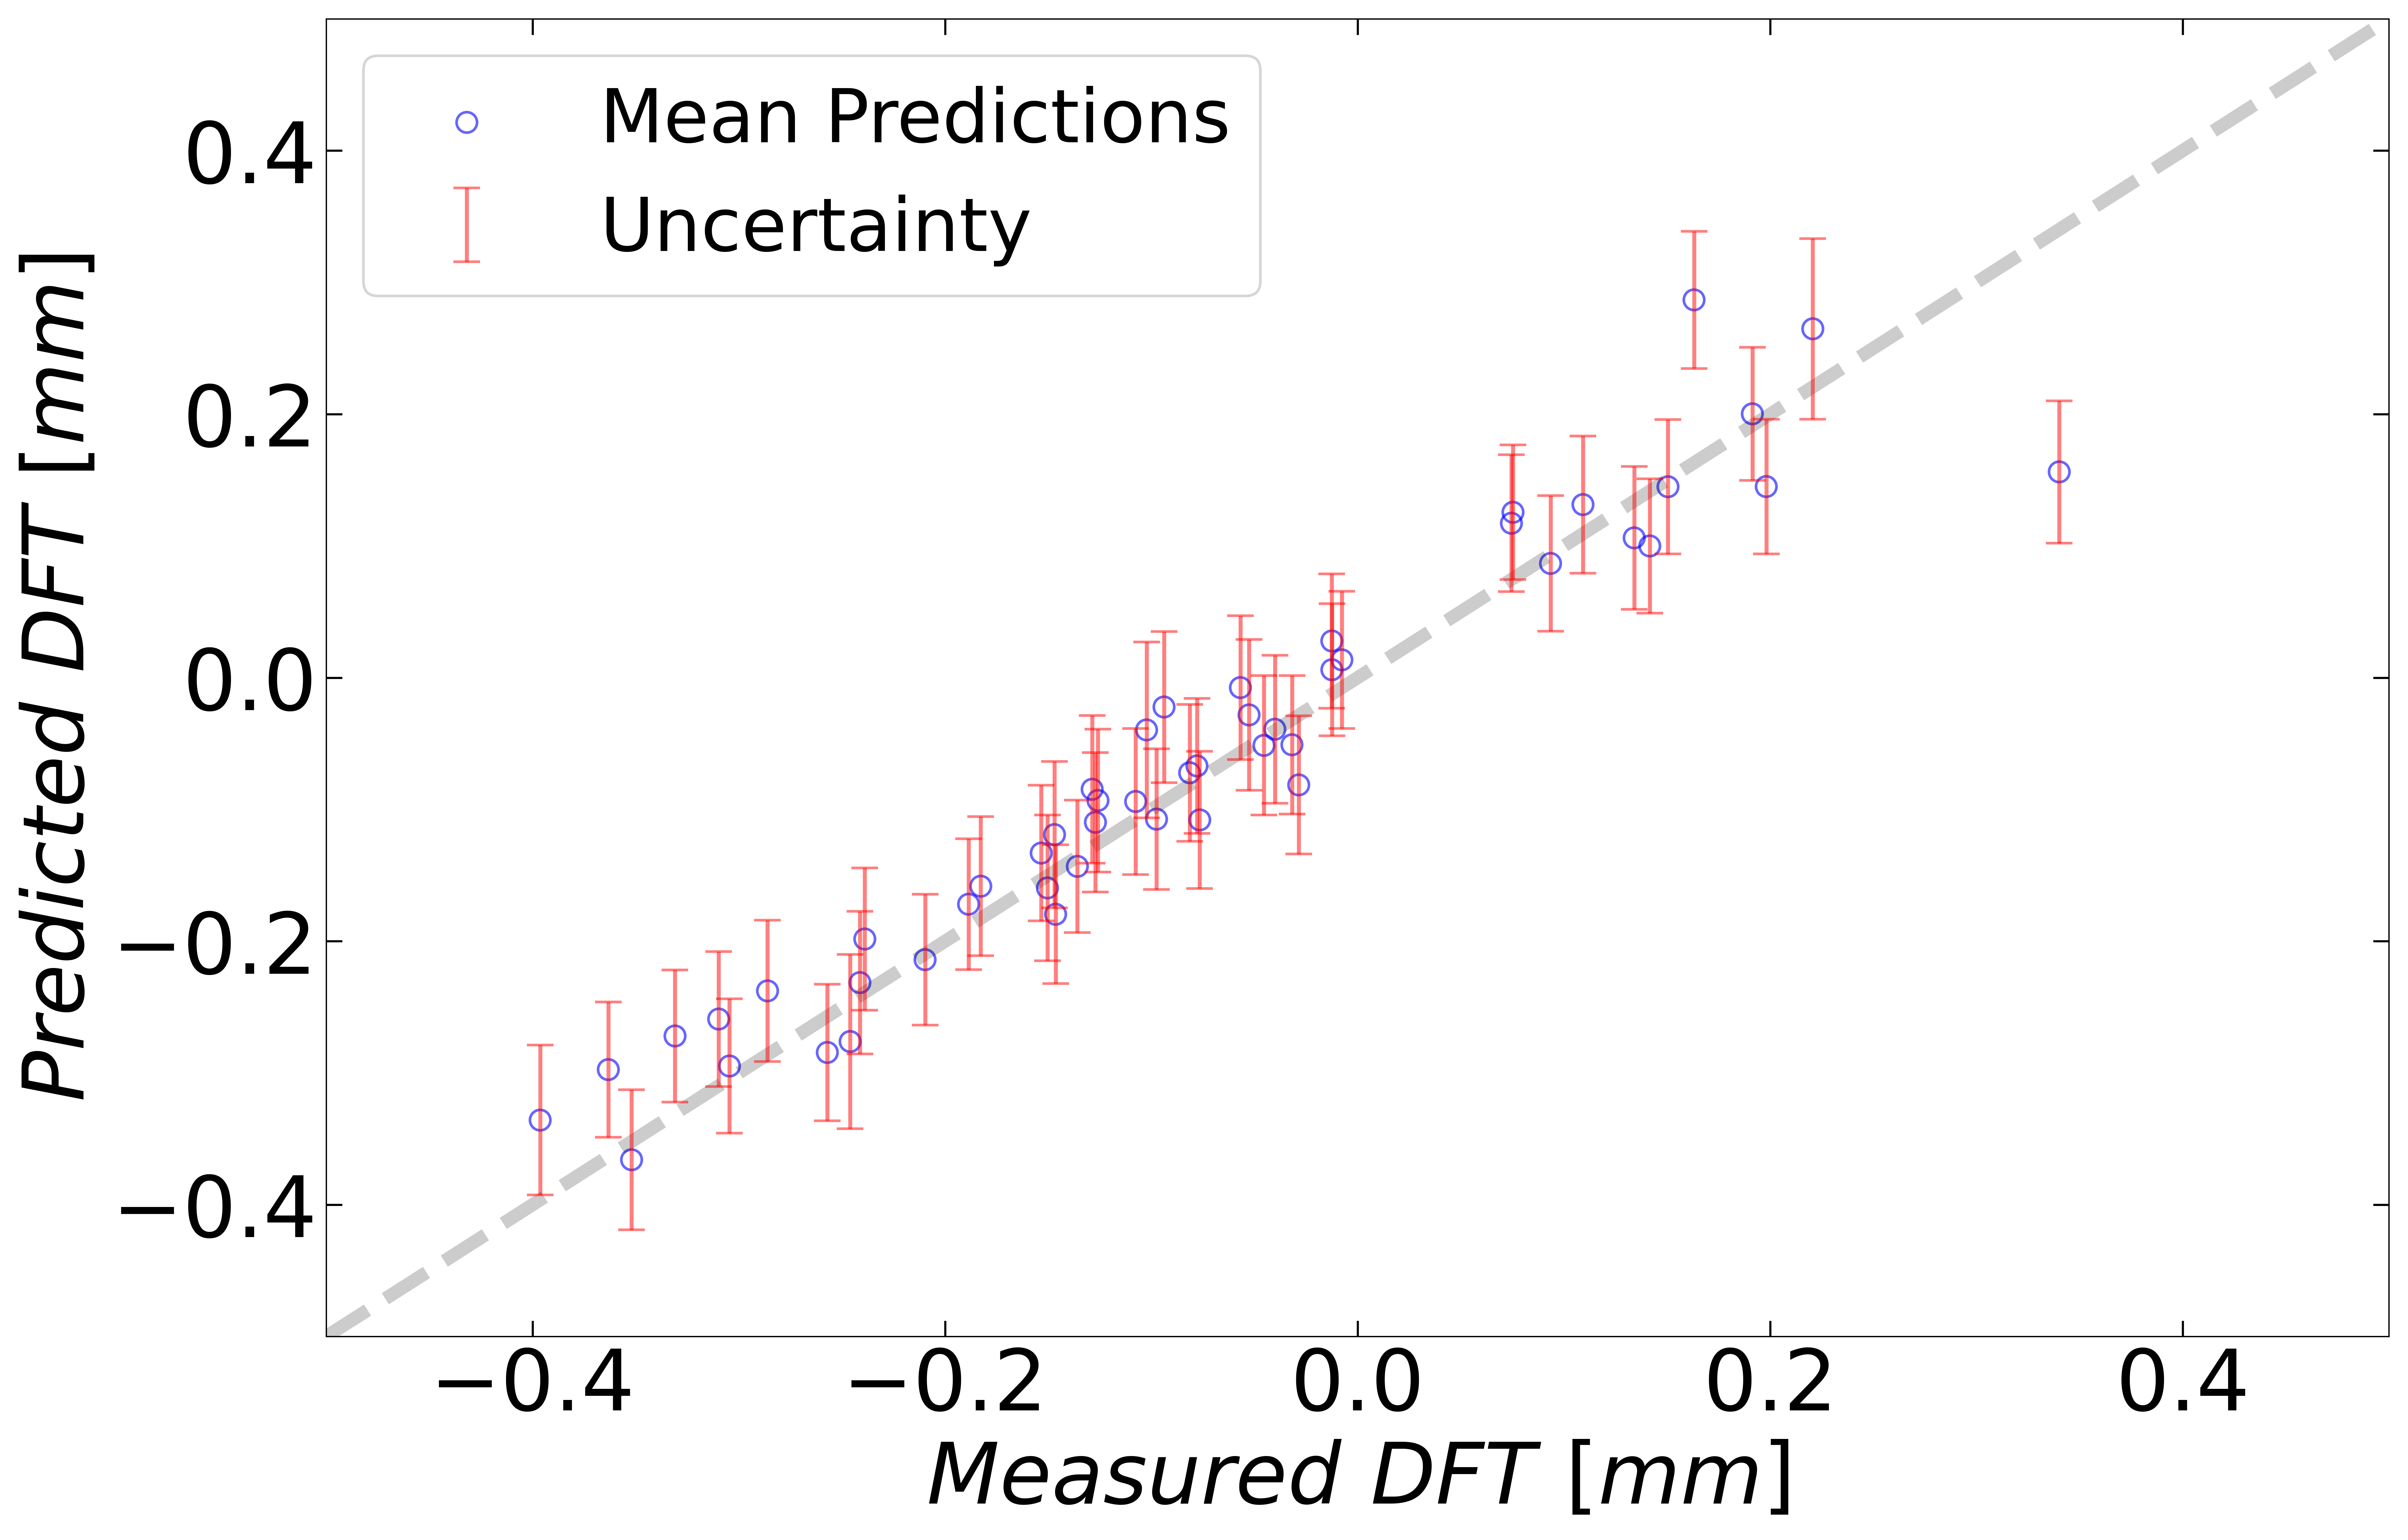

In [26]:
from matplotlib import rc
from matplotlib import rcParams


fontsize = 32

plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize)
rc('ytick', labelsize=fontsize)
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

fig, ((ax)) = plt.subplots(ncols=1, nrows=1, figsize=(14,9), dpi=600)


fontsize = 32

plt.rcParams['axes.linewidth'] = 0.5
rc('text', usetex=False)
rc('xtick', labelsize=fontsize)
rc('ytick', labelsize=fontsize)
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

## Parity plot for BNN (quantification of both aleatoric and epistemic uncertainty)

#--------------
ax.scatter(np.array(y_test).flatten()[0:50],np.array(mean_prediction).flatten()[0:50], s=60, facecolors='none', edgecolors='b', alpha=0.6, label='Mean Predictions')

ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-0.5, 0.5)

# 1:1 line for perfect predictions
x0, x1 = plt.gca().get_xlim()
y0, y1 = plt.gca().get_ylim()
lims = [max(x0, y0), min(x1, y1)]
plt.plot(lims, lims, '--k', linewidth=5, alpha=0.2)

ax.errorbar(np.array(y_test).flatten()[0:50], np.array(mean_prediction).flatten()[0:50], yerr=np.array(std_prediction).flatten()[0:50], fmt='none', color='red', alpha=0.5, capsize=5, label='Uncertainty')

#-----------------------------------------------------------------------------------------------------------------------------------------------------

# x_grid = np.linspace(0, 49, 50)

# ax.plot(mean_prediction.flatten()[0:50], linestyle='dashed', alpha=0.8, color='black', linewidth=2, label='Mean Prediction - GPR')
# ax.plot(np.array(y_test).flatten()[0:50], linestyle='solid', alpha=0.8, color='black', linewidth=2, label='Actual')

# ax.fill_between(x_grid, mean_prediction.flatten()[0:50] + 1.96*np.array(std_prediction[0:50]), mean_prediction.flatten()[0:50] - 1.96*np.array(std_prediction[0:50]), alpha=0.3, color='gray', label='Uncertainty')

# # ax.fill_between(x_grid, prediction_test[0:50] + 1.96*np.array(epistemic_CI[0:50]), prediction_test[0:50] - 1.96*np.array(epistemic_CI[0:50]), alpha=0.2,
# #                  color='crimson', label='Epistemic Uncertainty')

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fontsize=28)

## -----------------------------------------------------------------------------------------------------------------------------------------------------

# ax.set_ylabel(r'$Aleatoric$ $Uncertainty$ $[µm]$', fontweight ='bold', fontsize=fontsize)
# ax.set_xlabel(r'$Sampling$ $Fraction$ (% $Train$)', fontweight ='bold', fontsize=fontsize)

ax.set_ylabel(r'$Predicted$ $DFT$ $[mm]$', fontweight ='bold', fontsize=fontsize)
ax.set_xlabel(r'$Measured$ $DFT$ $[mm]$', fontweight ='bold', fontsize=fontsize)

# ax.set_ylim(-0.5, 0.5)
# ax.set_xlim(-0.5, 0.5)
ax.tick_params(left = True, right = True, top= True, bottom= True, which = 'both')
ax.legend(loc='upper left', fontsize=28)
plt.savefig("Plots/Quantification_GPR_Parity_Plot.png")
# ax.show()

# plt.legend(loc='upper right', fontsize = 20)
plt.show()